In [15]:
import librosa
import librosa.display
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import json

In [16]:
LIMITS = np.array([40, 80, 120, 180, 300, np.inf])


def get_peak_frequencies(y, sr=22_050, n_fft=2_048):
    """
    Extract peak frequencies for each FFT frame
    """
    S = np.abs(librosa.stft(y, n_fft=n_fft))

    all_frames = np.arange(S.shape[1])
    all_bins = np.arange(S.shape[0])

    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(all_frames)

    bands = np.array([np.argmax(LIMITS >= freq) for freq in all_bins])

    S_out = np.zeros_like(S, dtype=np.bool8)

    for band in np.unique(bands):
        start_row = np.argmax(bands == band)
        end_row = len(bands) - np.argmax(bands[::-1] == band)

        slice = S[start_row:end_row]

        # TODO: consider using moving window average instead
        # TODO: compute the mean only for single frame instead of song for comparison

        # Computing threshold by picking loudest freq in freq slice
        # and averaging their amplitudes (multiplied by a constant)
        amplitude_threshold = np.mean(np.max(slice, axis=0)) 

        # Max frequency bin index of a slice for each FFT frame
        # Not filtered by mean yet
        max_freq_bin = start_row + np.argmax(slice, axis=0)

        # Pick only frequencies, if their amplitude is higher than
        # the mean amplitude of the entire band captured from the whole song
        mask = S[max_freq_bin, all_frames] >= amplitude_threshold
        S_out[max_freq_bin[mask], all_frames[mask]] = True

    result = np.apply_along_axis(
        lambda key: np.array(
            [frequencies[key[0]], times[key[1]]]
        ),
        1,
        np.argwhere(S_out > 0)
    )

    result = result[result[:, 0].argsort()]
    result = result[result[:, 1].argsort(kind="mergesort")]

    return result


def get_hashes_from_peaks(peaks, window_size=5):
    """
    Constructs a sliding window to create a cluster of frequency peaks
    Resulting tuple / hash will have more entropy, thus reducing the computation cost
    """
    flat = np.apply_along_axis(
        lambda key: {"freq": key[0], "time": key[1]}, 1, peaks)

    hashes = []
    for window in np.lib.stride_tricks.sliding_window_view(flat, window_size):
        time = window[0]["time"]
        hash = ",".join([str(int(item["freq"])) for item in window])

        hashes.append({"time": time, "hash": hash})

    return hashes

# Figure out matches
# 1) Create a fingerprint from recording
# 2) Find the intersection of 2 fingerprints based on their hashes
# 3) Gather all deltas (distance between needle and search), count how many deltas are matching => sort by number of matching deltas
def compare_fingerprints(music_hashes, record_hashes):
    # Construct dict from music hashes
    db = defaultdict(list)

    for music in music_hashes:
        db[music["hash"]].append(music["time"])

    durations = defaultdict(int)
    for record in record_hashes:
        for music_time in db[record["hash"]]:
            delta = abs(music_time - record["time"])
            durations[str(delta)] += 1

    return sorted(durations.values())[-1]


In [17]:
# audio, sr = librosa.load(librosa.example('nutcracker'))
# audio_2, sr = librosa.load(librosa.example('brahms'))

recording, sample_rate = librosa.load("../tmp/33ab43e5e2624f3a27ff49a02.wav")
music, sample_rate = librosa.load(
    "../dataset/REEBOKS OR THE NIKES [fbHxkNa7lhQ].wav")


/opt/homebrew/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [18]:
def draw_filtered(music):
    f = get_peak_frequencies(music)
    S = np.abs(librosa.stft(music, n_fft=2048))

    all_frames = np.arange(S.shape[1])
    frequencies = librosa.fft_frequencies(sr=22_050, n_fft=2_048)
    times = librosa.frames_to_time(all_frames)


    plt.pcolormesh(times, frequencies, librosa.amplitude_to_db(S))
    plt.scatter(x=f[:, 1], y=f[:, 0], c="w", marker="+", linewidths=1)


    for i in range(len(LIMITS) - 1):
        plt.axhline(y=frequencies[int(LIMITS[i])], c="k")


In [22]:
recording, sr = librosa.load("/Users/duongtat/Work/_skola/VMM/tmp/7741cf05687b2db615fcef200.wav")
music, sr = librosa.load("/Users/duongtat/Work/_skola/VMM/dataset/REEBOKS OR THE NIKES [fbHxkNa7lhQ].wav")



/opt/homebrew/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


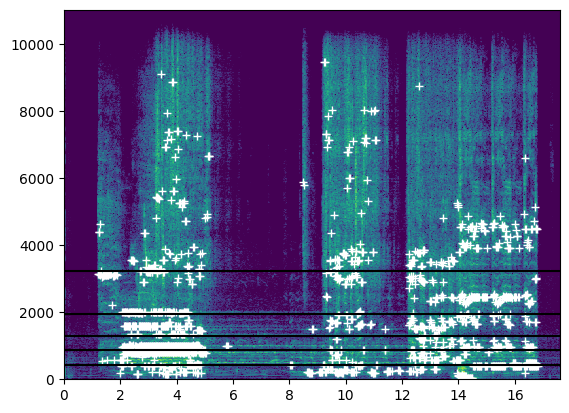

In [23]:
draw_filtered(recording)

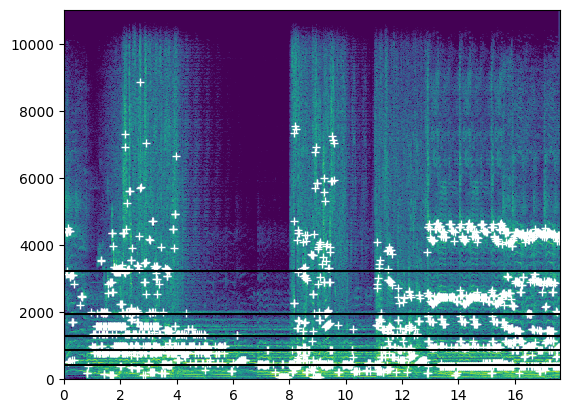

In [24]:
draw_filtered(music[:recording.shape[-1]])